In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data')

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# our place holders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, [None, real_dim], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_real, inputs_z

In [4]:
# gennrator network structure
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        h2 = tf.layers.dense(h1, n_units//4, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        # Logits and tanh(-1~1) output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        # Logits and sigmoid(0~1) output
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
# Size of input image to discriminator
input_size = 28 * 28 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# learning rate
learning_rate = 0.002
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

# Build Network

In [7]:
# wipe out previous graphs and make us to start building new graph from here
tf.reset_default_graph()

# Create our input placeholders
inputs_real, inputs_z = model_inputs(real_dim=input_size, z_dim=z_size)

# Generator network here(g_model is the generator output)
g_model = generator(z=inputs_z, out_dim=input_size, n_units=g_hidden_size, reuse=False, alpha=alpha)

# Disriminator network here
d_model_real, d_logits_real = discriminator(x=inputs_real, n_units=d_hidden_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(x=g_model, n_units=d_hidden_size, reuse=True, alpha=alpha)

In [8]:
# Calculate losses
real_labels = tf.ones_like(d_logits_real) * (1 - smooth) # label smoothing
d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels) )

fake_labels = tf.zeros_like(d_logits_real)
d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels) )

d_loss = d_loss_real + d_loss_fake

gen_labels = tf.ones_like(d_logits_fake)
g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=gen_labels) )

In [9]:
# Optimizers
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

# Training session

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_real: batch_images, inputs_z: batch_z})
        train_loss_g = g_loss.eval({inputs_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(inputs_z, input_size, n_units=g_hidden_size, reuse=True),
                       feed_dict={inputs_z: sample_z})
        samples.append(gen_samples)

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.5728... Generator Loss: 2.0731
Epoch 2/100... Discriminator Loss: 0.3833... Generator Loss: 6.2359
Epoch 3/100... Discriminator Loss: 0.6095... Generator Loss: 4.9883
Epoch 4/100... Discriminator Loss: 0.5153... Generator Loss: 5.5644
Epoch 5/100... Discriminator Loss: 1.1707... Generator Loss: 10.8453
Epoch 6/100... Discriminator Loss: 0.7436... Generator Loss: 3.2611
Epoch 7/100... Discriminator Loss: 1.2769... Generator Loss: 1.6923
Epoch 8/100... Discriminator Loss: 1.8629... Generator Loss: 5.6799
Epoch 9/100... Discriminator Loss: 2.2138... Generator Loss: 2.0805
Epoch 10/100... Discriminator Loss: 1.3768... Generator Loss: 1.3068
Epoch 11/100... Discriminator Loss: 1.1402... Generator Loss: 1.0905
Epoch 12/100... Discriminator Loss: 3.5880... Generator Loss: 1.1359
Epoch 13/100... Discriminator Loss: 1.4147... Generator Loss: 0.8899
Epoch 14/100... Discriminator Loss: 0.7331... Generator Loss: 1.4931
Epoch 15/100... Discriminator Loss: 1.2866

# Training loss

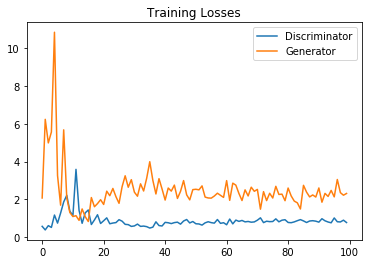

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Generator samples

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [13]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

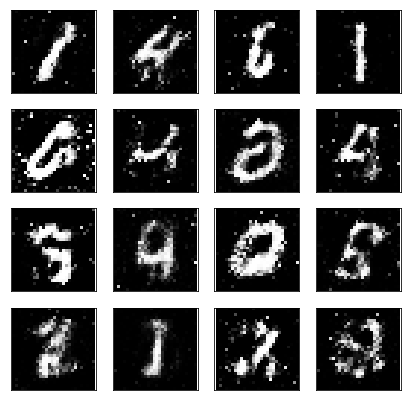

In [14]:
_ = view_samples(-1, samples)

In [ ]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)